# Feature Selection

In this notebook, we will show an example of how to use the GHEODE methodology for dealing with large climate datasets. In particular, we will be using the Hundred Hammers library for Auto ML.

## Loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gheode_methodology.utils import filter_dataset

In [2]:
df = pd.read_csv("../data/dataframe_lag-1_K-20_no-cnorm.csv")
df

,msl_cc_0,msl_cc_1,msl_cc_2,msl_cc_3,msl_cc_4,msl_cc_5,msl_cc_6,msl_cc_7,msl_cc_8,msl_cc_9,...,r_zi_4,r_zi_5,r_zi_6,r_zi_7,r_zi_8,season_spring,season_summer,season_fall,season_winter,target_tp
0,102774.555,101606.375,98541.695,101836.300,99910.760,100295.000,100460.020,99184.375,101447.875,98987.920,...,68.434320,66.696840,59.167236,62.127750,68.537285,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102459.890,101584.625,99628.336,101911.490,100081.980,98412.050,100312.020,98978.260,101578.240,99226.920,...,66.899610,65.824780,71.189850,69.310520,62.125670,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102349.240,101803.770,98930.180,101894.990,99196.650,100259.836,100020.010,99459.800,101498.125,98302.250,...,67.228530,63.367638,71.111580,69.913960,71.185570,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490190
3,102926.700,101689.390,99140.150,101886.310,99155.920,101464.040,99953.580,99241.080,101454.734,98632.950,...,60.181490,61.059868,61.021870,60.930157,58.795002,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102328.960,101663.460,100456.830,101808.450,99623.490,102716.390,100536.350,99358.260,101338.950,98710.230,...,44.702656,39.775370,31.059680,29.233988,27.226520,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102507.270,101810.750,99068.060,101762.170,98799.305,101092.680,99126.300,98299.336,101412.920,97048.560,...,61.932987,60.554268,60.000250,60.375908,59.757930,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,102261.740,101758.195,99227.620,101880.180,98722.750,101230.040,99360.040,98416.890,101535.336,97774.830,...,69.912476,72.905800,67.913280,71.166680,70.885010,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,103018.760,101737.760,99095.070,101949.290,98030.350,99875.266,98778.375,99664.710,101689.150,96022.040,...,68.518060,59.579770,68.117645,68.000570,65.350370,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102185.870,101826.180,99705.055,102001.664,99230.130,101261.820,100426.080,99764.640,101544.945,97012.445,...,28.756506,29.183332,35.088260,34.982582,34.433987,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


In [3]:
# number of clusters
K = 20
# attributes to use from the DataFrame
attr_names = ["msl", "sst", "t2m", "r"]
n_attrs = len(attr_names)

## Toying with `filter_datasets`

The `filter_datasets` function is the lifeblood of the GHEODE methodology: it receives a DataFrame, an array of lag times, timesteps and masks, and creates another dataset with the correct transformations. This is highly useful when searching for a set of features that is particularly informative in our problem.

For the function to work, every attribute in the input DataFrame must adhere to the format `{attr-name}_{agg-method}_{cluster-id}`, where:

1. `{attr-name}` is the name of the attribute (e.g. "msl", "sst", etc).
2. `{agg-method}` is the aggregation method that was used to produce the column data. Until now, we have mainly used "cm" (cluster mean; takes the mean of the cluster), "cc" (cluster centroid; takes the value at the cluster's centroid); and "zi" (zoomed in; does not separate in clusters but rather takes the value at a specific cell).
3. `{cluster-id}` is the ID of the cluster in question. 

For example, the column named `msl_cm_0` should be the `msl` data, aggregated via cluster mean, at the $0$-th cluster. 

Note that `{agg-method}` may be empty (if there is only one aggregation method and there is no need to differentiate them), or it may be an array (if different attributes should use different aggregation methods). Currently there is no way of selecting two different aggregation methods for the same attribute.

In [4]:
# Returning only the "cluster mean" data from the DataFrame inputted
filter_dataset(df, K, attr_names,
               lag_times=np.zeros((n_attrs, K), dtype=int),
               timesteps=np.ones((n_attrs, K), dtype=int),
               masks=np.ones(K, dtype=int),
               agg_method="cm",
               cols_to_maintain=["season_spring", "season_summer",
                                 "season_fall", "season_winter",
                                 "target_tp"])

,msl_cm_0_t-0,msl_cm_1_t-0,msl_cm_2_t-0,msl_cm_3_t-0,msl_cm_4_t-0,msl_cm_5_t-0,msl_cm_6_t-0,msl_cm_7_t-0,msl_cm_8_t-0,msl_cm_9_t-0,...,r_cm_15_t-0,r_cm_16_t-0,r_cm_17_t-0,r_cm_18_t-0,r_cm_19_t-0,season_spring,season_summer,season_fall,season_winter,target_tp
0,103090.590,101724.164,98926.305,101861.410,99846.530,99810.586,100415.305,98989.080,101422.140,98794.750,...,18.857190,22.704771,58.303852,52.721592,27.370834,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102677.300,101717.360,99040.730,101758.560,99945.030,99125.040,100351.260,99111.050,101581.310,98685.625,...,21.208904,28.722164,55.893200,47.796990,32.511936,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102858.920,101502.336,99118.150,101684.250,99063.940,100443.430,99927.734,99424.260,101599.140,98173.880,...,19.850100,27.997900,56.768948,45.284412,32.245950,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490190
3,102709.290,101676.260,99212.820,101710.016,99070.540,101535.910,99963.945,99213.125,101571.890,98488.766,...,17.950554,22.461882,60.609000,49.308823,28.185429,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102038.390,101644.234,99260.590,101637.290,99481.990,102065.180,100494.960,99387.914,101462.734,98087.840,...,20.396734,15.064026,59.844296,51.325510,30.773876,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102211.230,101624.250,99556.930,101931.280,98607.580,100631.610,99133.360,98419.914,101454.445,97057.195,...,32.771240,22.509802,54.039860,43.926567,27.644203,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,101878.734,101670.086,99619.110,102229.090,98700.375,101350.630,99509.360,98622.445,101546.790,97557.810,...,27.779730,21.583252,55.731567,43.414482,29.627197,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,102575.555,101654.836,99591.100,102163.875,98081.260,100938.530,98920.540,99614.670,101751.875,96540.900,...,17.201233,17.878101,57.052864,46.217674,27.976473,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102259.330,101817.350,99190.750,101999.240,99295.060,100804.516,100490.660,99591.990,101464.664,97173.310,...,24.867264,21.863613,54.616405,43.839226,27.970680,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


Notice that all columns (except the ones in `cols_to_maintain`) now end in `t-0`. This means that no time shift has been applied to them. We can change that by modifying `lag_times`:

In [5]:
# Returning the data from last week for each cluster
filter_dataset(df, K, attr_names,
               lag_times=np.ones((n_attrs, K), dtype=int),
               timesteps=np.ones((n_attrs, K), dtype=int),
               masks=np.ones(K, dtype=int),
               agg_method="cm",
               cols_to_maintain=["season_spring", "season_summer",
                                 "season_fall", "season_winter",
                                 "target_tp"])

,msl_cm_0_t-1,msl_cm_1_t-1,msl_cm_2_t-1,msl_cm_3_t-1,msl_cm_4_t-1,msl_cm_5_t-1,msl_cm_6_t-1,msl_cm_7_t-1,msl_cm_8_t-1,msl_cm_9_t-1,...,r_cm_15_t-1,r_cm_16_t-1,r_cm_17_t-1,r_cm_18_t-1,r_cm_19_t-1,season_spring,season_summer,season_fall,season_winter,target_tp
1,103090.590,101724.164,98926.305,101861.410,99846.530,99810.586,100415.305,98989.080,101422.140,98794.750,...,18.857190,22.704771,58.303852,52.721592,27.370834,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102677.300,101717.360,99040.730,101758.560,99945.030,99125.040,100351.260,99111.050,101581.310,98685.625,...,21.208904,28.722164,55.893200,47.796990,32.511936,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490190
3,102858.920,101502.336,99118.150,101684.250,99063.940,100443.430,99927.734,99424.260,101599.140,98173.880,...,19.850100,27.997900,56.768948,45.284412,32.245950,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102709.290,101676.260,99212.820,101710.016,99070.540,101535.910,99963.945,99213.125,101571.890,98488.766,...,17.950554,22.461882,60.609000,49.308823,28.185429,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358400
5,102038.390,101644.234,99260.590,101637.290,99481.990,102065.180,100494.960,99387.914,101462.734,98087.840,...,20.396734,15.064026,59.844296,51.325510,30.773876,1.482856e+01,6.420401e-05,1.271887e-17,1.152811e-37,4.899502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102192.664,101785.960,99302.750,102012.375,98826.625,101228.830,99959.414,99788.700,101271.086,97488.414,...,33.308754,24.101233,50.223614,39.857075,28.013445,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,102211.230,101624.250,99556.930,101931.280,98607.580,100631.610,99133.360,98419.914,101454.445,97057.195,...,32.771240,22.509802,54.039860,43.926567,27.644203,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,101878.734,101670.086,99619.110,102229.090,98700.375,101350.630,99509.360,98622.445,101546.790,97557.810,...,27.779730,21.583252,55.731567,43.414482,29.627197,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102575.555,101654.836,99591.100,102163.875,98081.260,100938.530,98920.540,99614.670,101751.875,96540.900,...,17.201233,17.878101,57.052864,46.217674,27.976473,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


We can, of course, randomize these three arrays (`lag_times`, `timesteps`, `masks`) to our heart's content.

In [6]:
# Default 'cm' DataFrame, but ignore each of the K clusters with 0.5 probability 
filter_dataset(df, K, attr_names,
               lag_times=np.zeros((n_attrs, K), dtype=int),
               timesteps=np.ones((n_attrs, K), dtype=int),
               masks=np.random.randint(0, 2, K),
               agg_method="cm",
               cols_to_maintain=["season_spring", "season_summer",
                                 "season_fall", "season_winter",
                                 "target_tp"])

,msl_cm_0_t-0,msl_cm_2_t-0,msl_cm_3_t-0,msl_cm_6_t-0,msl_cm_8_t-0,msl_cm_10_t-0,msl_cm_11_t-0,msl_cm_14_t-0,msl_cm_18_t-0,sst_cm_0_t-0,...,r_cm_8_t-0,r_cm_10_t-0,r_cm_11_t-0,r_cm_14_t-0,r_cm_18_t-0,season_spring,season_summer,season_fall,season_winter,target_tp
0,103090.590,98926.305,101861.410,100415.305,101422.140,99347.390,102590.520,102003.360,102482.660,0.0,...,32.159393,74.352040,18.720905,70.683000,52.721592,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102677.300,99040.730,101758.560,100351.260,101581.310,99394.300,102043.734,101753.770,101014.330,0.0,...,32.515034,77.866360,13.252409,64.498740,47.796990,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102858.920,99118.150,101684.250,99927.734,101599.140,98286.270,103567.950,102608.445,102026.195,0.0,...,34.024223,80.867890,15.492238,73.106040,45.284412,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490190
3,102709.290,99212.820,101710.016,99963.945,101571.890,98537.180,103218.280,101737.860,103283.195,0.0,...,30.712149,78.698586,17.787226,76.012150,49.308823,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102038.390,99260.590,101637.290,100494.960,101462.734,98761.390,103116.266,101884.860,103191.125,0.0,...,34.018875,79.957430,13.472571,77.519270,51.325510,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102211.230,99556.930,101931.280,99133.360,101454.445,98432.340,102502.730,101885.766,102453.580,0.0,...,54.333458,73.497750,24.865000,80.488235,43.926567,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,101878.734,99619.110,102229.090,99509.360,101546.790,97667.730,101225.950,100205.260,101425.490,0.0,...,53.638280,76.312290,16.230284,74.582950,43.414482,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,102575.555,99591.100,102163.875,98920.540,101751.875,97847.040,100413.586,100182.766,100545.200,0.0,...,40.095740,81.306330,20.749142,68.707760,46.217674,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102259.330,99190.750,101999.240,100490.660,101464.664,97468.414,101385.914,100925.190,102169.570,0.0,...,51.322560,78.408195,21.856441,68.506600,43.839226,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


In [7]:
# Default 'cm' DataFrame, but lag_times and timesteps can be anywhere from 1 to 3 
filter_dataset(df, K, attr_names,
               lag_times=np.random.randint(1, 4, (n_attrs, K)),
               timesteps=np.random.randint(1, 4, (n_attrs, K)),
               masks=np.ones(K, dtype=int),
               agg_method="cm",
               cols_to_maintain=["season_spring", "season_summer",
                                 "season_fall", "season_winter",
                                 "target_tp"])

,msl_cm_0_t-3,msl_cm_0_t-4,msl_cm_0_t-5,msl_cm_1_t-1,msl_cm_1_t-2,msl_cm_2_t-1,msl_cm_2_t-2,msl_cm_2_t-3,msl_cm_3_t-2,msl_cm_3_t-3,...,r_cm_16_t-4,r_cm_17_t-2,r_cm_18_t-2,r_cm_18_t-3,r_cm_19_t-1,season_spring,season_summer,season_fall,season_winter,target_tp
5,102858.920,102677.300,103090.590,101644.234,101676.260,99260.590,99212.82,99118.15,101710.016,101684.250,...,28.722164,60.609000,49.308823,45.284412,30.773876,1.482856e+01,6.420401e-05,1.271887e-17,1.152811e-37,4.899502
6,102709.290,102858.920,102677.300,101787.914,101644.234,99763.030,99260.59,99212.82,101637.290,101710.016,...,27.997900,59.844296,51.325510,49.308823,27.552933,1.904025e+01,3.024953e-04,2.198811e-16,7.312743e-36,17.768145
7,102038.390,102709.290,102858.920,101887.734,101787.914,99846.650,99763.03,99260.59,101765.780,101637.290,...,22.461882,59.789375,49.575672,51.325510,29.888031,2.212161e+01,1.289572e-03,3.439519e-15,4.197329e-34,19.899845
8,101763.305,102038.390,102709.290,101816.790,101887.734,99093.320,99846.65,99763.03,101881.210,101765.780,...,15.064026,56.756203,49.579580,49.575672,27.540524,2.325581e+01,4.974428e-03,4.868308e-14,2.179898e-32,26.686907
9,101695.484,101763.305,102038.390,101803.780,101816.790,99632.125,99093.32,99846.65,101953.610,101881.210,...,13.454600,64.225630,49.535442,49.579580,26.362940,2.212161e+01,1.736246e-02,6.234893e-13,1.024401e-30,13.228655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102160.290,101950.240,101727.390,101785.960,101771.240,99302.750,100249.31,99395.73,101877.840,101951.016,...,21.944756,48.785793,37.062760,38.333744,28.013445,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,101793.470,102160.290,101950.240,101624.250,101785.960,99556.930,99302.75,100249.31,102012.375,101877.840,...,21.328444,50.223614,39.857075,37.062760,27.644203,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,102192.664,101793.470,102160.290,101670.086,101624.250,99619.110,99556.93,99302.75,101931.280,102012.375,...,22.325829,54.039860,43.926567,39.857075,29.627197,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102211.230,102192.664,101793.470,101654.836,101670.086,99591.100,99619.11,99556.93,102229.090,101931.280,...,24.101233,55.731567,43.414482,43.926567,27.976473,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


## Training models

Next, we will use the **Hundred Hammers** AutoML library to run some tests on these datasets. 

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor

from hundred_hammers import HundredHammersRegressor, plot_batch_results
from hundred_hammers.model_zoo import DEFAULT_REGRESSION_MODELS

In [9]:
models = [(name, m, p) for (name, m, p) in DEFAULT_REGRESSION_MODELS if name not in ["Random Forest"]]
hh = HundredHammersRegressor(models=models, show_progress_bar=True)

In [10]:
_df = filter_dataset(df, K, attr_names,
                     lag_times=np.zeros((n_attrs, K), dtype=int),
                     timesteps=np.ones((n_attrs, K), dtype=int),
                     masks=np.ones(K, dtype=int),
                     agg_method="cm",
                     cols_to_maintain=["season_spring", "season_summer",
                                       "season_fall", "season_winter",
                                       "target_tp"])
X, y = _df.drop(columns=["target_tp"]).to_numpy(), _df["target_tp"].to_numpy()
X.shape, y.shape

((2242, 84), (2242,))

In [11]:
df_results = hh.evaluate(X, y, optim_hyper=False)
df_results

Evaluating models...:   0%|          | 0/13 [00:00<?, ?it/s][INFO] 2023-09-22 18:06:01,042: Running model [1/13]: Dummy Mean

        DummyRegressor:   0%|          | 0/10 [00:00<?, ?it/s]
                                                              [INFO] 2023-09-22 18:06:01,101: Metrics:
0: R2
	Validation Train: -13219522052111073700673256161280.000 ± 13064198033513141818935753048064.000
	Validation Test: -14046932402259341755318286680064.000 ± 12559115636742727754629578227712.000
	Train: -9132823674930484550175767396352.000 ± 11366499905808088107313004544000.000
	Test: -13280007282002061137927685013504.000 ± 12341451284743247687343157542912.000

1: MSE
	Validation Train: 332.032 ± 11.596
	Validation Test: 332.488 ± 34.117
	Train: 332.078 ± 8.101
	Test: 326.133 ± 32.369

2: MAE
	Validation Train: 14.071 ± 0.235
	Validation Test: 14.079 ± 0.531
	Train: 14.071 ± 0.166
	Test: 14.120 ± 0.551


[INFO] 2023-09-22 18:06:01,102: Running model [2/13]: Dummy Median

        DummyRegressor:   

,Model,Avg R2 (Validation Train),Std R2 (Validation Train),Avg R2 (Validation Test),Std R2 (Validation Test),Avg R2 (Train),Std R2 (Train),Avg R2 (Test),Std R2 (Test),Avg MSE (Validation Train),...,Avg MSE (Test),Std MSE (Test),Avg MAE (Validation Train),Std MAE (Validation Train),Avg MAE (Validation Test),Std MAE (Validation Test),Avg MAE (Train),Std MAE (Train),Avg MAE (Test),Std MAE (Test)
0,Dummy Mean,-1.321952e+31,1.306420e+31,-1.404693e+31,1.255912e+31,-9.132824e+30,1.136650e+31,-1.328001e+31,1.234145e+31,3.320319e+02,...,326.133407,32.368507,1.407053e+01,2.352797e-01,14.079330,0.530942,1.407138e+01,1.661773e-01,14.120048,0.551177
1,Dummy Median,-2.928125e+31,4.046029e+31,-4.436026e+31,4.500581e+31,-2.075169e+31,3.048654e+31,-4.137125e+31,5.155559e+31,3.541383e+02,...,347.410109,35.511122,1.362561e+01,2.155296e-01,13.637001,0.638920,1.362678e+01,1.484817e-01,13.677960,0.593365
2,Linear Regression,-3.640485e+00,3.528760e-01,-4.133623e+00,6.945267e-01,-3.967487e+00,3.047059e-01,-4.464711e+00,9.336879e-01,2.729120e+02,...,297.114036,27.193816,1.269755e+01,2.058774e-01,13.482784,0.591436,1.276924e+01,1.231854e-01,13.348624,0.361111
3,Decision Tree,1.000000e+00,0.000000e+00,-7.147904e-01,1.836975e-01,1.000000e+00,0.000000e+00,-7.796701e-01,1.825176e-01,0.000000e+00,...,579.639660,49.764945,0.000000e+00,0.000000e+00,18.069684,1.037069,0.000000e+00,0.000000e+00,17.955280,0.666934
4,SVR,-3.685340e+07,1.329583e+07,-3.737578e+07,1.419928e+07,-2.272244e+07,4.766135e+06,-2.227596e+07,5.162942e+06,3.540488e+02,...,347.389939,35.582560,1.362517e+01,2.155092e-01,13.636629,0.638985,1.362624e+01,1.484652e-01,13.676777,0.593024
5,Linear SVR,-6.113093e+01,9.101348e+01,-6.226347e+01,9.221010e+01,-4.897820e+01,3.429540e+01,-4.996921e+01,3.629925e+01,6.556778e+02,...,623.142889,464.694514,1.892153e+01,9.000211e+00,19.047276,9.319595,1.906281e+01,7.399170e+00,19.058107,7.866595
6,Ridge,-3.716623e+00,3.558024e-01,-4.206868e+00,7.019012e-01,-4.027318e+00,3.050988e-01,-4.523571e+00,9.432287e-01,2.730022e+02,...,296.430548,27.115701,1.270218e+01,2.066077e-01,13.467293,0.589648,1.277298e+01,1.234707e-01,13.335847,0.361360
7,Passive Aggressive,-3.123477e+04,2.722951e+04,-3.150024e+04,2.756050e+04,-2.663460e+04,1.499006e+04,-2.587265e+04,1.369594e+04,5.843769e+02,...,500.916814,140.273491,1.812442e+01,6.846563e+00,18.037672,6.684191,1.708334e+01,2.778882e+00,17.092645,3.012868
8,KNN,-2.112813e+00,1.769791e-01,-3.882575e+00,6.648406e-01,-2.082728e+00,1.003184e-01,-3.698972e+00,6.292709e-01,2.459811e+02,...,366.681970,35.098151,1.188152e+01,2.496357e-01,14.573505,0.573804,1.185872e+01,2.067202e-01,14.703363,0.614619
9,Neural Network Regressor,-5.838757e-02,8.321198e-02,-6.614473e-02,1.007970e-01,-5.839188e-02,5.526821e-02,-4.976024e-02,5.247970e-02,8.934372e+04,...,87505.150321,54264.893868,2.279825e+02,7.156942e+01,228.819899,74.186966,2.244354e+02,6.484448e+01,225.891667,66.206661


C:\Users\vgarcia\Documents\GitHub\gheode-methodology\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\vgarcia\Documents\GitHub\gheode-methodology\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\vgarcia\Documents\GitHub\gheode-methodology\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\vgarcia\Documents\GitHub\gheode-methodology\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_d

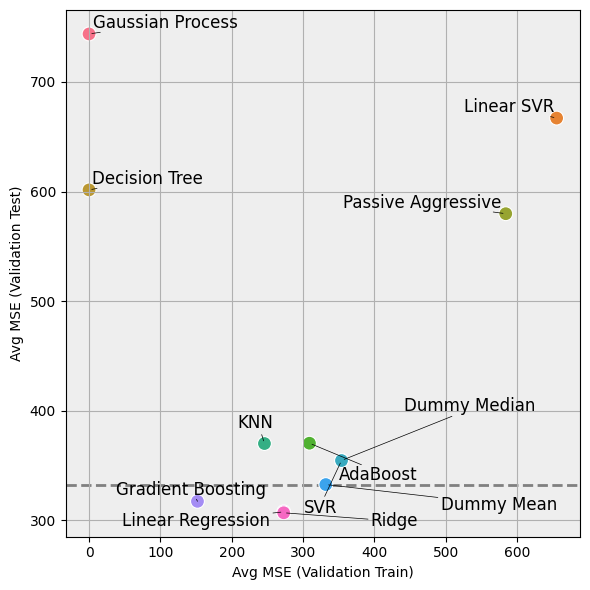

In [12]:
plot_batch_results(df_results, "MSE", ignore_first_n=1)